# Train a reinforcement model that follows the line

First we import the necessary simulator libraries
- CarModel: a simulated car
- CanvasModel: a simulated training ground where the car can follow a line
- SimulatorControl: an environment where we can simulate actions like driving forward or turning left and right and read out new sensor values

In [3]:
import logging
import Car
import Canvas
import RobotCarSimulator

In [4]:
car = Car.CarModel()
# the seed controls the curve/line that we are following
canvas = Canvas.CanvasModel(seed=11)
# we set createGif to False to save space and runtime - we will generate the video once we apply the trained model
sim = RobotCarSimulator.SimulatorControl(canvas, car, createGif=False)

Model hyperparameters

In [5]:
GAMMA = 0.995             # discount factor
ALPHA = 1e-2              # learning rate  
TAU = 1e-2                # soft update
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps
MEMORY_SIZE = 100_000     # size of memory buffer
MINIBATCH_SIZE = 64   # mini-batch size
E_DECAY = 0.995       # ε decay rate for ε-greedy policy
E_MIN = 0.01          # minimum ε value for ε-greedy policy

## Action space

- 0 - driveForward(100,150)
- 1 - turnLeft(100,50)
- 2 - turnRight(100,50)

In [6]:
def driveForward():
    global sim
    sim.driveForward(100,150)

def turnLeft():
    global sim
    sim.turnLeft(100,50)
    
def turnRight():
    global sim
    sim.turnRight(100,50)
    
actions = (driveForward, turnLeft, turnRight)

num_actions = len(actions)

#to invoke action 0:
#actions[0]()

## Observation space

the observation space is only the sensor values of the 3 infrared sensors (two time steps ) ==>
- current sensor values
- previous sensor values

In [7]:
import numpy as np

def getReward():
    global sim
    return sim.getReward()

def getSensors():
    global sim
    return sim.getPreviousLineTrackingSensorValues() + sim.getLineTrackingSensorValues()

def getDuration():
    global sim
    return sim.getDuration()

def isDone():
    global sim
    return sim.isTerminated()


# run one step and return next state (sensors), reward, done and time exceeded
def step(action):
    action()
    return (np.array(getSensors()), isDone(), getReward(), getDuration())
    
next_state, done, reward, duration = step(actions[0])     
    
state_size = 6 # we have three sensors and two time steps (2 * 3)

print(next_state, done, reward, duration) 

[ 30.         557.35703254 814.33883274  30.         146.91333487
 900.        ] False 20.0 0.25


# Deep Q-learning (reinforcement learning)

as learned in the coursera course we will use two models, the Q and target Q' networks (Deep Q Network) DQN.

In [8]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
from collections import deque, namedtuple # for experience replay
import numpy as np
import random

In [9]:
# Create the Q-Network
q_network = Sequential([
    ### START CODE HERE ### 
    Input(shape=state_size),                      
    Dense(units=64, activation='relu'),            
    Dense(units=64, activation='relu'),            
    Dense(units=num_actions, activation='linear'),
    ### END CODE HERE ### 
    ])

# Create the target Q^-Network
target_q_network = Sequential([
    ### START CODE HERE ### 
    Input(shape=state_size),                      
    Dense(units=64, activation='relu'),            
    Dense(units=64, activation='relu'),            
    Dense(units=num_actions, activation='linear'),
    ### END CODE HERE ###
    ])


optimizer = Adam(learning_rate=ALPHA)           


2022-08-23 15:49:53.421874: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-23 15:49:53.422170: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


## Experience replay 

The coursera course recommends to use experience replay to avoid problematic correlations, oscillations and instabilities. In addition, experience replay also allows the agent to potentially use the same experience in multiple weight updates, which increases data efficiency.

In [10]:
# Store experiences as named tuples
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [11]:
# calculate_loss

def compute_loss(experiences, gamma, q_network, target_q_network):
    """ 
    Calculates the loss.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Karas model for predicting the targets
          
    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """
    
    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences
    
    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    
    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    ### START CODE HERE ### 
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))
    ### END CODE HERE ###
    
    # Get the q_values
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))
        
    # Compute the loss
    ### START CODE HERE ### 
    loss = MSE(y_targets, q_values)
    ### END CODE HERE ### 
    
    return loss

In [12]:
def update_target_network(q_network, target_q_network):
    for target_weights, q_net_weights in zip(target_q_network.weights, q_network.weights):
        target_weights.assign(TAU * q_net_weights + (1.0 - TAU) * target_weights)

In [13]:
@tf.function
def agent_learn(experiences, gamma):
    """
    Updates the weights of the Q networks.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
    
    """
    
    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)
    
    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target q_network
    update_target_network(q_network, target_q_network)

In [14]:
def get_action(q_values, epsilon=0):
    if random.random() > epsilon:
        return np.argmax(q_values.numpy()[0])
    else:
        return random.choice(np.arange(num_actions))

In [15]:
def check_update_conditions(t, num_steps_upd, memory_buffer):
    if (t + 1) % num_steps_upd == 0 and len(memory_buffer) > MINIBATCH_SIZE:
        return True
    else:
        return False

In [16]:
def get_experiences(memory_buffer):
    experiences = random.sample(memory_buffer, k=MINIBATCH_SIZE)
    states = tf.convert_to_tensor(np.array([e.state for e in experiences if e is not None]),dtype=tf.float32)
    actions = tf.convert_to_tensor(np.array([e.action for e in experiences if e is not None]), dtype=tf.float32)
    rewards = tf.convert_to_tensor(np.array([e.reward for e in experiences if e is not None]), dtype=tf.float32)
    next_states = tf.convert_to_tensor(np.array([e.next_state for e in experiences if e is not None]),dtype=tf.float32)
    done_vals = tf.convert_to_tensor(np.array([e.done for e in experiences if e is not None]).astype(np.uint8),
                                     dtype=tf.float32)
    return (states, actions, rewards, next_states, done_vals)

In [17]:
def get_new_eps(epsilon):
    return max(E_MIN, E_DECAY*epsilon)

In [18]:
import time
import pprint
import sys
start = time.time()

num_episodes = 2000
max_num_timesteps = 200

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())
# learn with 9 different curves to generalize the model and not optimize for a single curve
seeds = (2,5,9,11,13,15,17,19,21)

duration = 0.0

for i in range(num_episodes):
    
    # Reset the environment to the initial state and get the initial state
    car = Car.CarModel()
    # the seed controls the curve/line that we are following
    seed = seeds[i%len(seeds)]
    canvas = Canvas.CanvasModel(seed=seed)
    # we set createGif to False to save space and runtime - we will generate the video once we apply the trained model
    sim = RobotCarSimulator.SimulatorControl(canvas, car, createGif=False)
    state = np.array(getSensors())
    total_points = 0
    
    for t in range(max_num_timesteps):
        
        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
        q_values = q_network(state_qn)
        action = get_action(q_values, epsilon)
        
        # Take action A and receive reward R and the next state S'
        next_state, done, reward, duration = step(actions[action])   
       
        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))
        
        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        
        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = get_experiences(memory_buffer)
            
            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            #print("\nUpdating model after ",t," steps")
            agent_learn(experiences, GAMMA)
        
        state = next_state.copy()
        total_points += reward
        
        if done:
            print("\nBreaking episode ",i," with seed ", seed, " after ",t," steps with reward ",total_points)
            break
        if (t==(max_num_timesteps-1)):
            print("\nAborting episode ",i," with seed ", seed, " after ",t," steps with reward ",total_points)
            
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
    
    # Update the ε value
    epsilon = get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")
        with open('train_episode_{}_seed_{}.txt'.format(i,seed), 'w') as f:
            f.write("actions:\n")
            f.write(pprint.pformat(sim._actionLog))
            f.write("\n\npositions:\n")
            f.write(pprint.pformat(sim._carPositions))
            f.write("\n\norientations:\n")
            f.write(pprint.pformat(sim._carOrientations))

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 40000.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('curve_tracking_model.h5')
        break
        
tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")
q_network.save('curve_tracking_model.h5')


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


Breaking episode  0  with seed  2  after  99  steps with reward  -14330.0
Episode 1 | Total point average of the last 100 episodes: -14330.00
Breaking episode  1  with seed  5  after  120  steps with reward  -13820.0
Episode 2 | Total point average of the last 100 episodes: -14075.00
Breaking episode  2  with seed  9  after  51  steps with reward  -23180.0
Episode 3 | Total point average of the last 100 episodes: -17110.00
Breaking episode  3  with seed  11  after  148  steps with reward  -33100.0
Epis

Episode 52 | Total point average of the last 100 episodes: -25915.77
Breaking episode  52  with seed  19  after  51  steps with reward  -3480.0
Episode 53 | Total point average of the last 100 episodes: -25492.45
Breaking episode  53  with seed  21  after  117  steps with reward  -30170.0
Episode 54 | Total point average of the last 100 episodes: -25579.07
Breaking episode  54  with seed  2  after  25  steps with reward  -2000.0
Episode 55 | Total point average of the last 100 episodes: -25150.36
Breaking episode  55  with seed  5  after  138  steps with reward  -13880.0
Episode 56 | Total point average of the last 100 episodes: -24949.11
Breaking episode  56  with seed  9  after  38  steps with reward  -21070.0
Episode 57 | Total point average of the last 100 episodes: -24881.05
Breaking episode  57  with seed  11  after  74  steps with reward  -5040.0
Episode 58 | Total point average of the last 100 episodes: -24538.97
Breaking episode  58  with seed  13  after  165  steps with rewar

Episode 109 | Total point average of the last 100 episodes: -16252.20
Aborting episode  109  with seed  5  after  199  steps with reward  -20850.0
Episode 110 | Total point average of the last 100 episodes: -16119.00
Breaking episode  110  with seed  9  after  45  steps with reward  -19950.0
Episode 111 | Total point average of the last 100 episodes: -15991.30
Aborting episode  111  with seed  11  after  199  steps with reward  -7200.0
Episode 112 | Total point average of the last 100 episodes: -15729.30
Aborting episode  112  with seed  13  after  199  steps with reward  -18840.0
Episode 113 | Total point average of the last 100 episodes: -15602.10
Breaking episode  113  with seed  15  after  5  steps with reward  -14970.0
Episode 114 | Total point average of the last 100 episodes: -15537.70
Aborting episode  114  with seed  17  after  199  steps with reward  -11210.0
Episode 115 | Total point average of the last 100 episodes: -15345.20
Breaking episode  115  with seed  19  after  28 

Episode 165 | Total point average of the last 100 episodes: -4630.30
Aborting episode  165  with seed  11  after  199  steps with reward  -16440.0
Episode 166 | Total point average of the last 100 episodes: -4614.10
Breaking episode  166  with seed  13  after  144  steps with reward  19450.0
Episode 167 | Total point average of the last 100 episodes: -4384.50
Breaking episode  167  with seed  15  after  13  steps with reward  -14970.0
Episode 168 | Total point average of the last 100 episodes: -4350.60
Aborting episode  168  with seed  17  after  199  steps with reward  -4330.0
Episode 169 | Total point average of the last 100 episodes: -4394.20
Breaking episode  169  with seed  19  after  63  steps with reward  -1060.0
Episode 170 | Total point average of the last 100 episodes: -4243.90
Aborting episode  170  with seed  21  after  199  steps with reward  -3540.0
Episode 171 | Total point average of the last 100 episodes: -4284.10
Breaking episode  171  with seed  2  after  166  steps 

Episode 222 | Total point average of the last 100 episodes: 488.10
Breaking episode  222  with seed  17  after  184  steps with reward  21770.0
Episode 223 | Total point average of the last 100 episodes: 705.50
Breaking episode  223  with seed  19  after  29  steps with reward  380.0
Episode 224 | Total point average of the last 100 episodes: 671.50
Breaking episode  224  with seed  21  after  132  steps with reward  -11460.0
Episode 225 | Total point average of the last 100 episodes: 589.10
Breaking episode  225  with seed  2  after  135  steps with reward  20050.0
Episode 226 | Total point average of the last 100 episodes: 602.30
Aborting episode  226  with seed  5  after  199  steps with reward  6600.0
Episode 227 | Total point average of the last 100 episodes: 786.20
Aborting episode  227  with seed  9  after  199  steps with reward  8140.0
Episode 228 | Total point average of the last 100 episodes: 900.30
Aborting episode  228  with seed  11  after  199  steps with reward  3870.0


Episode 279 | Total point average of the last 100 episodes: 4753.50
Aborting episode  279  with seed  2  after  199  steps with reward  -7850.0
Episode 280 | Total point average of the last 100 episodes: 4472.80
Breaking episode  280  with seed  5  after  175  steps with reward  -8880.0
Episode 281 | Total point average of the last 100 episodes: 4169.30
Aborting episode  281  with seed  9  after  199  steps with reward  5040.0
Episode 282 | Total point average of the last 100 episodes: 4233.20
Breaking episode  282  with seed  11  after  156  steps with reward  20130.0
Episode 283 | Total point average of the last 100 episodes: 4369.60
Breaking episode  283  with seed  13  after  81  steps with reward  20240.0
Episode 284 | Total point average of the last 100 episodes: 4604.90
Breaking episode  284  with seed  15  after  5  steps with reward  -14970.0
Episode 285 | Total point average of the last 100 episodes: 4248.60
Aborting episode  285  with seed  17  after  199  steps with reward 

Episode 336 | Total point average of the last 100 episodes: 7166.20
Aborting episode  336  with seed  11  after  199  steps with reward  3540.0
Episode 337 | Total point average of the last 100 episodes: 7259.10
Breaking episode  337  with seed  13  after  65  steps with reward  19840.0
Episode 338 | Total point average of the last 100 episodes: 7420.30
Breaking episode  338  with seed  15  after  143  steps with reward  1550.0
Episode 339 | Total point average of the last 100 episodes: 7232.90
Aborting episode  339  with seed  17  after  199  steps with reward  5110.0
Episode 340 | Total point average of the last 100 episodes: 7073.60
Aborting episode  340  with seed  19  after  199  steps with reward  5020.0
Episode 341 | Total point average of the last 100 episodes: 7135.30
Aborting episode  341  with seed  21  after  199  steps with reward  4960.0
Episode 342 | Total point average of the last 100 episodes: 7225.80
Breaking episode  342  with seed  2  after  197  steps with reward  

Episode 393 | Total point average of the last 100 episodes: 6812.30
Aborting episode  393  with seed  17  after  199  steps with reward  6750.0
Episode 394 | Total point average of the last 100 episodes: 7029.50
Breaking episode  394  with seed  19  after  136  steps with reward  22120.0
Episode 395 | Total point average of the last 100 episodes: 7275.30
Breaking episode  395  with seed  21  after  116  steps with reward  18700.0
Episode 396 | Total point average of the last 100 episodes: 7244.00
Breaking episode  396  with seed  2  after  106  steps with reward  21300.0
Episode 397 | Total point average of the last 100 episodes: 7248.70
Aborting episode  397  with seed  5  after  199  steps with reward  2070.0
Episode 398 | Total point average of the last 100 episodes: 7054.00
Aborting episode  398  with seed  9  after  199  steps with reward  5160.0
Episode 399 | Total point average of the last 100 episodes: 7041.40
Aborting episode  399  with seed  11  after  199  steps with reward 

Episode 450 | Total point average of the last 100 episodes: 7206.50
Breaking episode  450  with seed  2  after  114  steps with reward  21800.0
Episode 451 | Total point average of the last 100 episodes: 7225.90
Aborting episode  451  with seed  5  after  199  steps with reward  -4440.0
Episode 452 | Total point average of the last 100 episodes: 6967.00
Breaking episode  452  with seed  9  after  77  steps with reward  680.0
Episode 453 | Total point average of the last 100 episodes: 6979.00
Breaking episode  453  with seed  11  after  100  steps with reward  20120.0
Episode 454 | Total point average of the last 100 episodes: 7158.30
Breaking episode  454  with seed  13  after  84  steps with reward  19340.0
Episode 455 | Total point average of the last 100 episodes: 7410.50
Aborting episode  455  with seed  15  after  199  steps with reward  5890.0
Episode 456 | Total point average of the last 100 episodes: 7274.60
Aborting episode  456  with seed  17  after  199  steps with reward  4

Episode 507 | Total point average of the last 100 episodes: 6725.00
Breaking episode  507  with seed  11  after  163  steps with reward  20850.0
Episode 508 | Total point average of the last 100 episodes: 6864.00
Breaking episode  508  with seed  13  after  130  steps with reward  20510.0
Episode 509 | Total point average of the last 100 episodes: 6845.80
Breaking episode  509  with seed  15  after  3  steps with reward  -14970.0
Episode 510 | Total point average of the last 100 episodes: 6497.70
Aborting episode  510  with seed  17  after  199  steps with reward  3000.0
Episode 511 | Total point average of the last 100 episodes: 6495.20
Aborting episode  511  with seed  19  after  199  steps with reward  5140.0
Episode 512 | Total point average of the last 100 episodes: 6503.20
Aborting episode  512  with seed  21  after  199  steps with reward  5540.0
Episode 513 | Total point average of the last 100 episodes: 6552.00
Aborting episode  513  with seed  2  after  199  steps with reward

Episode 564 | Total point average of the last 100 episodes: 6484.10
Aborting episode  564  with seed  17  after  199  steps with reward  4180.0
Episode 565 | Total point average of the last 100 episodes: 6675.60
Aborting episode  565  with seed  19  after  199  steps with reward  960.0
Episode 566 | Total point average of the last 100 episodes: 6606.50
Aborting episode  566  with seed  21  after  199  steps with reward  6810.0
Episode 567 | Total point average of the last 100 episodes: 6820.20
Aborting episode  567  with seed  2  after  199  steps with reward  4390.0
Episode 568 | Total point average of the last 100 episodes: 6655.30
Aborting episode  568  with seed  5  after  199  steps with reward  6240.0
Episode 569 | Total point average of the last 100 episodes: 6501.00
Aborting episode  569  with seed  9  after  199  steps with reward  5620.0
Episode 570 | Total point average of the last 100 episodes: 6505.10
Aborting episode  570  with seed  11  after  199  steps with reward  346

Episode 621 | Total point average of the last 100 episodes: 7582.20
Breaking episode  621  with seed  2  after  81  steps with reward  750.0
Episode 622 | Total point average of the last 100 episodes: 7373.50
Aborting episode  622  with seed  5  after  199  steps with reward  5820.0
Episode 623 | Total point average of the last 100 episodes: 7214.10
Breaking episode  623  with seed  9  after  64  steps with reward  590.0
Episode 624 | Total point average of the last 100 episodes: 7173.30
Breaking episode  624  with seed  11  after  164  steps with reward  21210.0
Episode 625 | Total point average of the last 100 episodes: 7375.50
Breaking episode  625  with seed  13  after  103  steps with reward  19450.0
Episode 626 | Total point average of the last 100 episodes: 7523.70
Breaking episode  626  with seed  15  after  3  steps with reward  -14970.0
Episode 627 | Total point average of the last 100 episodes: 7170.60
Aborting episode  627  with seed  17  after  199  steps with reward  3300

Episode 678 | Total point average of the last 100 episodes: 6710.60
Aborting episode  678  with seed  11  after  199  steps with reward  4030.0
Episode 679 | Total point average of the last 100 episodes: 6705.00
Breaking episode  679  with seed  13  after  57  steps with reward  20020.0
Episode 680 | Total point average of the last 100 episodes: 6882.80
Breaking episode  680  with seed  15  after  167  steps with reward  21260.0
Episode 681 | Total point average of the last 100 episodes: 6910.20
Aborting episode  681  with seed  17  after  199  steps with reward  6340.0
Episode 682 | Total point average of the last 100 episodes: 7123.30
Breaking episode  682  with seed  19  after  145  steps with reward  22470.0
Episode 683 | Total point average of the last 100 episodes: 7295.80
Breaking episode  683  with seed  21  after  187  steps with reward  19730.0
Episode 684 | Total point average of the last 100 episodes: 7431.80
Aborting episode  684  with seed  2  after  199  steps with rewar

Episode 735 | Total point average of the last 100 episodes: 8605.80
Breaking episode  735  with seed  17  after  183  steps with reward  3170.0
Episode 736 | Total point average of the last 100 episodes: 8787.20
Breaking episode  736  with seed  19  after  124  steps with reward  18360.0
Episode 737 | Total point average of the last 100 episodes: 8926.40
Breaking episode  737  with seed  21  after  168  steps with reward  18510.0
Episode 738 | Total point average of the last 100 episodes: 9051.80
Breaking episode  738  with seed  2  after  87  steps with reward  18890.0
Episode 739 | Total point average of the last 100 episodes: 9190.90
Breaking episode  739  with seed  5  after  195  steps with reward  19460.0
Episode 740 | Total point average of the last 100 episodes: 9363.70
Breaking episode  740  with seed  9  after  16  steps with reward  -14850.0
Episode 741 | Total point average of the last 100 episodes: 9174.80
Breaking episode  741  with seed  11  after  99  steps with reward 

Episode 792 | Total point average of the last 100 episodes: 10808.20
Breaking episode  792  with seed  2  after  155  steps with reward  20460.0
Episode 793 | Total point average of the last 100 episodes: 10944.20
Breaking episode  793  with seed  5  after  104  steps with reward  21070.0
Episode 794 | Total point average of the last 100 episodes: 10946.50
Breaking episode  794  with seed  9  after  16  steps with reward  -14850.0
Episode 795 | Total point average of the last 100 episodes: 10740.70
Aborting episode  795  with seed  11  after  199  steps with reward  4920.0
Episode 796 | Total point average of the last 100 episodes: 10731.30
Breaking episode  796  with seed  13  after  87  steps with reward  17960.0
Episode 797 | Total point average of the last 100 episodes: 10872.00
Breaking episode  797  with seed  15  after  180  steps with reward  20630.0
Episode 798 | Total point average of the last 100 episodes: 10884.90
Aborting episode  798  with seed  17  after  199  steps with

Episode 849 | Total point average of the last 100 episodes: 10609.70
Breaking episode  849  with seed  11  after  122  steps with reward  20330.0
Episode 850 | Total point average of the last 100 episodes: 10797.10
Breaking episode  850  with seed  13  after  131  steps with reward  19480.0
Episode 851 | Total point average of the last 100 episodes: 10984.20
Aborting episode  851  with seed  15  after  199  steps with reward  2830.0
Episode 852 | Total point average of the last 100 episodes: 10807.50
Aborting episode  852  with seed  17  after  199  steps with reward  2980.0
Episode 853 | Total point average of the last 100 episodes: 10624.00
Breaking episode  853  with seed  19  after  173  steps with reward  22470.0
Episode 854 | Total point average of the last 100 episodes: 10814.10
Breaking episode  854  with seed  21  after  110  steps with reward  18330.0
Episode 855 | Total point average of the last 100 episodes: 10956.90
Breaking episode  855  with seed  2  after  111  steps wi

Episode 905 | Total point average of the last 100 episodes: 10699.30
Breaking episode  905  with seed  15  after  78  steps with reward  18880.0
Episode 906 | Total point average of the last 100 episodes: 10702.70
Breaking episode  906  with seed  17  after  117  steps with reward  20310.0
Episode 907 | Total point average of the last 100 episodes: 10725.70
Breaking episode  907  with seed  19  after  180  steps with reward  19020.0
Episode 908 | Total point average of the last 100 episodes: 10877.20
Breaking episode  908  with seed  21  after  96  steps with reward  19070.0
Episode 909 | Total point average of the last 100 episodes: 10885.70
Breaking episode  909  with seed  2  after  68  steps with reward  18230.0
Episode 910 | Total point average of the last 100 episodes: 10868.10
Breaking episode  910  with seed  5  after  142  steps with reward  19910.0
Episode 911 | Total point average of the last 100 episodes: 10890.40
Breaking episode  911  with seed  9  after  16  steps with r

Episode 962 | Total point average of the last 100 episodes: 11396.30
Breaking episode  962  with seed  21  after  100  steps with reward  19080.0
Episode 963 | Total point average of the last 100 episodes: 11411.80
Breaking episode  963  with seed  2  after  98  steps with reward  19870.0
Episode 964 | Total point average of the last 100 episodes: 11411.50
Aborting episode  964  with seed  5  after  199  steps with reward  3790.0
Episode 965 | Total point average of the last 100 episodes: 11277.10
Aborting episode  965  with seed  9  after  199  steps with reward  4070.0
Episode 966 | Total point average of the last 100 episodes: 11287.60
Breaking episode  966  with seed  11  after  120  steps with reward  19390.0
Episode 967 | Total point average of the last 100 episodes: 11630.00
Breaking episode  967  with seed  13  after  53  steps with reward  18010.0
Episode 968 | Total point average of the last 100 episodes: 11797.50
Breaking episode  968  with seed  15  after  102  steps with r

Episode 1018 | Total point average of the last 100 episodes: 11871.40
Breaking episode  1018  with seed  5  after  148  steps with reward  21900.0
Episode 1019 | Total point average of the last 100 episodes: 11909.10
Breaking episode  1019  with seed  9  after  16  steps with reward  -14850.0
Episode 1020 | Total point average of the last 100 episodes: 11695.70
Breaking episode  1020  with seed  11  after  129  steps with reward  18360.0
Episode 1021 | Total point average of the last 100 episodes: 11867.10
Breaking episode  1021  with seed  13  after  74  steps with reward  18190.0
Episode 1022 | Total point average of the last 100 episodes: 11869.60
Breaking episode  1022  with seed  15  after  128  steps with reward  18380.0
Episode 1023 | Total point average of the last 100 episodes: 11881.30
Breaking episode  1023  with seed  17  after  154  steps with reward  2050.0
Episode 1024 | Total point average of the last 100 episodes: 11697.00
Breaking episode  1024  with seed  19  after  

Episode 1074 | Total point average of the last 100 episodes: 10733.30
Breaking episode  1074  with seed  11  after  90  steps with reward  18640.0
Episode 1075 | Total point average of the last 100 episodes: 10851.50
Breaking episode  1075  with seed  13  after  144  steps with reward  18570.0
Episode 1076 | Total point average of the last 100 episodes: 10855.90
Breaking episode  1076  with seed  15  after  170  steps with reward  18780.0
Episode 1077 | Total point average of the last 100 episodes: 10851.50
Breaking episode  1077  with seed  17  after  109  steps with reward  19070.0
Episode 1078 | Total point average of the last 100 episodes: 11191.90
Breaking episode  1078  with seed  19  after  40  steps with reward  -14120.0
Episode 1079 | Total point average of the last 100 episodes: 11024.00
Aborting episode  1079  with seed  21  after  199  steps with reward  5630.0
Episode 1080 | Total point average of the last 100 episodes: 10866.70
Breaking episode  1080  with seed  2  after 

Episode 1130 | Total point average of the last 100 episodes: 12475.40
Breaking episode  1130  with seed  15  after  134  steps with reward  19270.0
Episode 1131 | Total point average of the last 100 episodes: 12481.30
Breaking episode  1131  with seed  17  after  136  steps with reward  1150.0
Episode 1132 | Total point average of the last 100 episodes: 12642.50
Breaking episode  1132  with seed  19  after  176  steps with reward  21310.0
Episode 1133 | Total point average of the last 100 episodes: 12830.10
Breaking episode  1133  with seed  21  after  101  steps with reward  18720.0
Episode 1134 | Total point average of the last 100 episodes: 12826.30
Breaking episode  1134  with seed  2  after  127  steps with reward  18740.0
Episode 1135 | Total point average of the last 100 episodes: 12996.30
Aborting episode  1135  with seed  5  after  199  steps with reward  4020.0
Episode 1136 | Total point average of the last 100 episodes: 12863.70
Breaking episode  1136  with seed  9  after  1

Episode 1186 | Total point average of the last 100 episodes: 13411.90
Breaking episode  1186  with seed  19  after  144  steps with reward  20850.0
Episode 1187 | Total point average of the last 100 episodes: 13407.00
Breaking episode  1187  with seed  21  after  148  steps with reward  20770.0
Episode 1188 | Total point average of the last 100 episodes: 13409.50
Breaking episode  1188  with seed  2  after  90  steps with reward  20180.0
Episode 1189 | Total point average of the last 100 episodes: 13425.60
Breaking episode  1189  with seed  5  after  170  steps with reward  22500.0
Episode 1190 | Total point average of the last 100 episodes: 13448.20
Breaking episode  1190  with seed  9  after  61  steps with reward  1100.0
Episode 1191 | Total point average of the last 100 episodes: 13239.60
Aborting episode  1191  with seed  11  after  199  steps with reward  3890.0
Episode 1192 | Total point average of the last 100 episodes: 13267.00
Aborting episode  1192  with seed  13  after  199

Episode 1242 | Total point average of the last 100 episodes: 10591.50
Breaking episode  1242  with seed  2  after  107  steps with reward  17740.0
Episode 1243 | Total point average of the last 100 episodes: 10597.00
Breaking episode  1243  with seed  5  after  140  steps with reward  20520.0
Episode 1244 | Total point average of the last 100 episodes: 10599.30
Breaking episode  1244  with seed  9  after  16  steps with reward  -14850.0
Episode 1245 | Total point average of the last 100 episodes: 10248.70
Breaking episode  1245  with seed  11  after  96  steps with reward  17680.0
Episode 1246 | Total point average of the last 100 episodes: 10202.70
Breaking episode  1246  with seed  13  after  88  steps with reward  18080.0
Episode 1247 | Total point average of the last 100 episodes: 10183.10
Breaking episode  1247  with seed  15  after  120  steps with reward  18180.0
Episode 1248 | Total point average of the last 100 episodes: 10183.40
Breaking episode  1248  with seed  17  after  1

Episode 1298 | Total point average of the last 100 episodes: 10299.00
Aborting episode  1298  with seed  9  after  199  steps with reward  5580.0
Episode 1299 | Total point average of the last 100 episodes: 10308.00
Aborting episode  1299  with seed  11  after  199  steps with reward  2860.0
Episode 1300 | Total point average of the last 100 episodes: 10479.70

Breaking episode  1300  with seed  13  after  74  steps with reward  18050.0
Episode 1301 | Total point average of the last 100 episodes: 10653.70
Breaking episode  1301  with seed  15  after  121  steps with reward  17270.0
Episode 1302 | Total point average of the last 100 episodes: 10778.20
Breaking episode  1302  with seed  17  after  145  steps with reward  2910.0
Episode 1303 | Total point average of the last 100 episodes: 10617.10
Breaking episode  1303  with seed  19  after  140  steps with reward  19440.0
Episode 1304 | Total point average of the last 100 episodes: 10792.40
Breaking episode  1304  with seed  21  after  

Episode 1354 | Total point average of the last 100 episodes: 12240.80
Breaking episode  1354  with seed  13  after  61  steps with reward  18570.0
Episode 1355 | Total point average of the last 100 episodes: 12242.40
Breaking episode  1355  with seed  15  after  130  steps with reward  21210.0
Episode 1356 | Total point average of the last 100 episodes: 12278.00
Breaking episode  1356  with seed  17  after  100  steps with reward  20820.0
Episode 1357 | Total point average of the last 100 episodes: 12298.50
Breaking episode  1357  with seed  19  after  162  steps with reward  17760.0
Episode 1358 | Total point average of the last 100 episodes: 12273.10
Breaking episode  1358  with seed  21  after  108  steps with reward  18270.0
Episode 1359 | Total point average of the last 100 episodes: 12443.50
Breaking episode  1359  with seed  2  after  140  steps with reward  20700.0
Episode 1360 | Total point average of the last 100 episodes: 12454.30
Breaking episode  1360  with seed  5  after 

Episode 1410 | Total point average of the last 100 episodes: 12460.00
Breaking episode  1410  with seed  17  after  177  steps with reward  3980.0
Episode 1411 | Total point average of the last 100 episodes: 12317.00
Aborting episode  1411  with seed  19  after  199  steps with reward  3120.0
Episode 1412 | Total point average of the last 100 episodes: 12309.50
Breaking episode  1412  with seed  21  after  164  steps with reward  19040.0
Episode 1413 | Total point average of the last 100 episodes: 12301.50
Breaking episode  1413  with seed  2  after  114  steps with reward  19120.0
Episode 1414 | Total point average of the last 100 episodes: 12469.30
Aborting episode  1414  with seed  5  after  199  steps with reward  5230.0
Episode 1415 | Total point average of the last 100 episodes: 12319.70
Breaking episode  1415  with seed  9  after  28  steps with reward  -14840.0
Episode 1416 | Total point average of the last 100 episodes: 12113.20
Breaking episode  1416  with seed  11  after  12

Episode 1466 | Total point average of the last 100 episodes: 11801.80
Breaking episode  1466  with seed  21  after  125  steps with reward  19810.0
Episode 1467 | Total point average of the last 100 episodes: 11961.60
Breaking episode  1467  with seed  2  after  141  steps with reward  18710.0
Episode 1468 | Total point average of the last 100 episodes: 11946.30
Aborting episode  1468  with seed  5  after  199  steps with reward  4410.0
Episode 1469 | Total point average of the last 100 episodes: 11777.20
Breaking episode  1469  with seed  9  after  44  steps with reward  -14720.0
Episode 1470 | Total point average of the last 100 episodes: 11414.40
Aborting episode  1470  with seed  11  after  199  steps with reward  2200.0
Episode 1471 | Total point average of the last 100 episodes: 11584.90
Breaking episode  1471  with seed  13  after  65  steps with reward  18080.0
Episode 1472 | Total point average of the last 100 episodes: 11580.10
Breaking episode  1472  with seed  15  after  17

Episode 1522 | Total point average of the last 100 episodes: 11335.40
Aborting episode  1522  with seed  5  after  199  steps with reward  2770.0
Episode 1523 | Total point average of the last 100 episodes: 11189.70
Breaking episode  1523  with seed  9  after  169  steps with reward  22520.0
Episode 1524 | Total point average of the last 100 episodes: 11201.80
Breaking episode  1524  with seed  11  after  98  steps with reward  22170.0
Episode 1525 | Total point average of the last 100 episodes: 11568.60
Breaking episode  1525  with seed  13  after  47  steps with reward  16700.0
Episode 1526 | Total point average of the last 100 episodes: 11717.40
Breaking episode  1526  with seed  15  after  115  steps with reward  18910.0
Episode 1527 | Total point average of the last 100 episodes: 11725.30
Breaking episode  1527  with seed  17  after  182  steps with reward  3400.0
Episode 1528 | Total point average of the last 100 episodes: 11909.00
Breaking episode  1528  with seed  19  after  14

Episode 1578 | Total point average of the last 100 episodes: 11654.60
Aborting episode  1578  with seed  11  after  199  steps with reward  3270.0
Episode 1579 | Total point average of the last 100 episodes: 11676.60
Breaking episode  1579  with seed  13  after  123  steps with reward  19110.0
Episode 1580 | Total point average of the last 100 episodes: 11674.30
Aborting episode  1580  with seed  15  after  199  steps with reward  3580.0
Episode 1581 | Total point average of the last 100 episodes: 11527.50
Aborting episode  1581  with seed  17  after  199  steps with reward  2430.0
Episode 1582 | Total point average of the last 100 episodes: 11532.40
Breaking episode  1582  with seed  19  after  193  steps with reward  19260.0
Episode 1583 | Total point average of the last 100 episodes: 11697.70
Aborting episode  1583  with seed  21  after  199  steps with reward  5550.0
Episode 1584 | Total point average of the last 100 episodes: 11716.90
Breaking episode  1584  with seed  2  after  1

Episode 1634 | Total point average of the last 100 episodes: 11140.20
Breaking episode  1634  with seed  15  after  114  steps with reward  19530.0
Episode 1635 | Total point average of the last 100 episodes: 11170.40
Aborting episode  1635  with seed  17  after  199  steps with reward  3860.0
Episode 1636 | Total point average of the last 100 episodes: 11358.70
Breaking episode  1636  with seed  19  after  144  steps with reward  20730.0
Episode 1637 | Total point average of the last 100 episodes: 11377.50
Breaking episode  1637  with seed  21  after  175  steps with reward  18780.0
Episode 1638 | Total point average of the last 100 episodes: 11378.50
Breaking episode  1638  with seed  2  after  139  steps with reward  18450.0
Episode 1639 | Total point average of the last 100 episodes: 11369.20
Breaking episode  1639  with seed  5  after  108  steps with reward  22790.0
Episode 1640 | Total point average of the last 100 episodes: 11398.90
Breaking episode  1640  with seed  9  after  

Episode 1690 | Total point average of the last 100 episodes: 11056.00
Breaking episode  1690  with seed  19  after  150  steps with reward  18660.0
Episode 1691 | Total point average of the last 100 episodes: 11215.10
Breaking episode  1691  with seed  21  after  120  steps with reward  17450.0
Episode 1692 | Total point average of the last 100 episodes: 11190.50
Breaking episode  1692  with seed  2  after  100  steps with reward  16570.0
Episode 1693 | Total point average of the last 100 episodes: 11171.70
Breaking episode  1693  with seed  5  after  157  steps with reward  20130.0
Episode 1694 | Total point average of the last 100 episodes: 11185.80
Breaking episode  1694  with seed  9  after  36  steps with reward  -14510.0
Episode 1695 | Total point average of the last 100 episodes: 11003.10
Breaking episode  1695  with seed  11  after  151  steps with reward  19770.0
Episode 1696 | Total point average of the last 100 episodes: 11149.30
Breaking episode  1696  with seed  13  after 

Episode 1746 | Total point average of the last 100 episodes: 11111.70
Breaking episode  1746  with seed  2  after  68  steps with reward  18980.0
Episode 1747 | Total point average of the last 100 episodes: 11114.80
Aborting episode  1747  with seed  5  after  199  steps with reward  3860.0
Episode 1748 | Total point average of the last 100 episodes: 10944.20
Breaking episode  1748  with seed  9  after  44  steps with reward  -14700.0
Episode 1749 | Total point average of the last 100 episodes: 10744.10
Breaking episode  1749  with seed  11  after  116  steps with reward  19830.0
Episode 1750 | Total point average of the last 100 episodes: 10739.30
Breaking episode  1750  with seed  13  after  61  steps with reward  19490.0
Episode 1751 | Total point average of the last 100 episodes: 10752.40
Breaking episode  1751  with seed  15  after  110  steps with reward  18690.0
Episode 1752 | Total point average of the last 100 episodes: 10759.20
Breaking episode  1752  with seed  17  after  14

Episode 1802 | Total point average of the last 100 episodes: 11291.30
Aborting episode  1802  with seed  9  after  199  steps with reward  4350.0
Episode 1803 | Total point average of the last 100 episodes: 11299.80
Breaking episode  1803  with seed  11  after  123  steps with reward  22310.0
Episode 1804 | Total point average of the last 100 episodes: 11509.50
Breaking episode  1804  with seed  13  after  93  steps with reward  18270.0
Episode 1805 | Total point average of the last 100 episodes: 11664.60
Aborting episode  1805  with seed  15  after  199  steps with reward  3880.0
Episode 1806 | Total point average of the last 100 episodes: 11525.60
Breaking episode  1806  with seed  17  after  146  steps with reward  20090.0
Episode 1807 | Total point average of the last 100 episodes: 11548.20
Breaking episode  1807  with seed  19  after  111  steps with reward  20960.0
Episode 1808 | Total point average of the last 100 episodes: 11567.60
Aborting episode  1808  with seed  21  after  

Episode 1858 | Total point average of the last 100 episodes: 11125.70
Breaking episode  1858  with seed  13  after  65  steps with reward  17400.0
Episode 1859 | Total point average of the last 100 episodes: 11283.60
Breaking episode  1859  with seed  15  after  3  steps with reward  -14970.0
Episode 1860 | Total point average of the last 100 episodes: 10963.20
Breaking episode  1860  with seed  17  after  117  steps with reward  19800.0
Episode 1861 | Total point average of the last 100 episodes: 10964.20
Aborting episode  1861  with seed  19  after  199  steps with reward  4970.0
Episode 1862 | Total point average of the last 100 episodes: 10971.00
Breaking episode  1862  with seed  21  after  165  steps with reward  18660.0
Episode 1863 | Total point average of the last 100 episodes: 10971.70
Breaking episode  1863  with seed  2  after  124  steps with reward  21280.0
Episode 1864 | Total point average of the last 100 episodes: 11007.70
Breaking episode  1864  with seed  5  after  1

Episode 1914 | Total point average of the last 100 episodes: 10528.60
Aborting episode  1914  with seed  17  after  199  steps with reward  2240.0
Episode 1915 | Total point average of the last 100 episodes: 10349.00
Breaking episode  1915  with seed  19  after  108  steps with reward  18250.0
Episode 1916 | Total point average of the last 100 episodes: 10322.60
Breaking episode  1916  with seed  21  after  147  steps with reward  19700.0
Episode 1917 | Total point average of the last 100 episodes: 10490.60
Breaking episode  1917  with seed  2  after  68  steps with reward  17200.0
Episode 1918 | Total point average of the last 100 episodes: 10608.30
Aborting episode  1918  with seed  5  after  199  steps with reward  5640.0
Episode 1919 | Total point average of the last 100 episodes: 10465.50
Aborting episode  1919  with seed  9  after  199  steps with reward  2430.0
Episode 1920 | Total point average of the last 100 episodes: 10442.30
Breaking episode  1920  with seed  11  after  142

Episode 1970 | Total point average of the last 100 episodes: 12157.60
Breaking episode  1970  with seed  21  after  98  steps with reward  16490.0
Episode 1971 | Total point average of the last 100 episodes: 12284.80
Breaking episode  1971  with seed  2  after  112  steps with reward  18440.0
Episode 1972 | Total point average of the last 100 episodes: 12291.50
Aborting episode  1972  with seed  5  after  199  steps with reward  3990.0
Episode 1973 | Total point average of the last 100 episodes: 12156.50
Breaking episode  1973  with seed  9  after  49  steps with reward  -14640.0
Episode 1974 | Total point average of the last 100 episodes: 11984.40
Breaking episode  1974  with seed  11  after  114  steps with reward  18630.0
Episode 1975 | Total point average of the last 100 episodes: 12120.40
Breaking episode  1975  with seed  13  after  48  steps with reward  18840.0
Episode 1976 | Total point average of the last 100 episodes: 12124.10
Breaking episode  1976  with seed  15  after  17

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

def plot_history(reward_history, rolling_window=20, lower_limit=None,
                 upper_limit=None, plot_rw=True, plot_rm=True):
    
    if lower_limit is None or upper_limit is None:
        rh = reward_history
        xs = [x for x in range(len(reward_history))]
    else:
        rh = reward_history[lower_limit:upper_limit]
        xs = [x for x in range(lower_limit,upper_limit)]
    
    df = pd.DataFrame(rh)
    rollingMean = df.rolling(rolling_window).mean()

    plt.figure(figsize=(10,7), facecolor='white')
    
    if plot_rw:
        plt.plot(xs, rh, linewidth=1, color='cyan')
    if plot_rm:
        plt.plot(xs, rollingMean, linewidth=2, color='magenta')

    text_color = 'black'
        
    ax = plt.gca()
    ax.set_facecolor('black')
    plt.grid()
#     plt.title("Total Point History", color=text_color, fontsize=40)
    plt.xlabel('Episode', color=text_color, fontsize=30)
    plt.ylabel('Total Points', color=text_color, fontsize=30)
    yNumFmt = mticker.StrMethodFormatter('{x:,}')
    ax.yaxis.set_major_formatter(yNumFmt)
    ax.tick_params(axis='x', colors=text_color)
    ax.tick_params(axis='y', colors=text_color)
    plt.show()
    

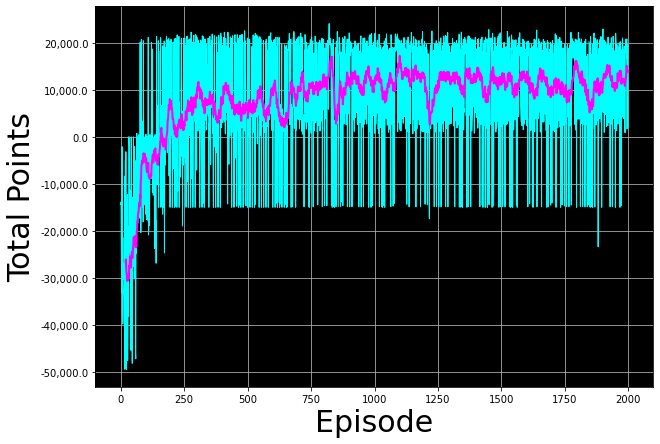

In [20]:
# Plot the point history
plot_history(total_point_history)

# Apply learned model and revisit results

In [21]:
import pprint
import sys
import logging
import Car
import Canvas
import RobotCarSimulator
import tensorflow as tf
from tensorflow.keras import Sequential
import numpy as np

model = tf.keras.models.load_model('curve_tracking_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                448       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 4,803
Trainable params: 4,803
Non-trainable params: 0
_________________________________________________________________


In [25]:
def driveForward():
    global sim
    sim.driveForward(100,150)

def turnLeft():
    global sim
    sim.turnLeft(100,50)
    
def turnRight():
    global sim
    sim.turnRight(100,50)
    
actions = (driveForward, turnLeft, turnRight)

# training curves used seeds (2,5,9,11,13,15,17,19,21)
# we use 7, and 23 in addition to see how the model performs on unknown curves
for seed in (2,5,7,9,11,13,15,17,19,21,23):
    car = Car.CarModel()
    # the seed controls the curve/line that we are following
    canvas = Canvas.CanvasModel(seed=seed)
    # we set createGif to False to save space and runtime - we will generate the video once we apply the trained model
    sim = RobotCarSimulator.SimulatorControl(canvas, car, createGif=True)

    while not sim.isTerminated() and sim.getDuration() < 20.0:
        state_qn = np.expand_dims(np.array(sim.getPreviousLineTrackingSensorValues() + sim.getLineTrackingSensorValues()), axis=0)
        q_values = model(state_qn)
        action = np.argmax(q_values.numpy()[0])
        actions[action]()

    sim.saveImage('model_seed_{}.gif'.format(seed))
    with open('model_seed_{}.txt'.format(seed), 'w') as f:
        f.write("actions:\n")
        f.write(pprint.pformat(sim._actionLog))
        f.write("\n\npositions:\n")
        f.write(pprint.pformat(sim._carPositions))
        f.write("\n\norientations:\n")
        f.write(pprint.pformat(sim._carOrientations))